Using kernel `conda_pytorch_latest_p36`

In [3]:
import sys
sys.path.append('../../../')

In [4]:
from pathlib import Path
import os
import random
import pickle
import tarfile
from typing import List
from dataclasses import dataclass

In [5]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
import torch
import pandas as pd
import numpy as np
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast, Trainer, TrainingArguments
from sklearn.metrics import classification_report, precision_recall_fscore_support, precision_score, f1_score, recall_score, multilabel_confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import torch
import boto3
from langdetect import detect

In [6]:
from deep.constants import *

## Data

### Entail Data

In [20]:
def preprocessing(df):
    df = df.copy()
    df['sectors'] = df['sectors'].apply(eval)    
    df['pillars'] = df['pillars'].apply(eval)
    df['pillars'] = df['pillars'].apply(lambda x: list(set(x)))
    df['subpillars'] = df['subpillars'].apply(eval)
    return df

In [21]:
column = 'subpillars'
classes=SUBPILLARS
text_column = 'excerpt'
entail_text_column = 'entail_excerpt'
label_column = 'entail_labels'

In [22]:
train = preprocessing(pd.read_csv(LATEST_DATA_PATH / 'data_v0.4.4_train.csv', index_col=0))
val = preprocessing(pd.read_csv(LATEST_DATA_PATH / 'data_v0.4.4_val.csv', index_col=0))
test = preprocessing(pd.read_csv(LATEST_DATA_PATH / 'data_v0.4.4_test.csv', index_col=0))

In [23]:
def process_entailment(df, train, column, classes, only_en=True, drop_empty=True):
    df = df.copy()
    
    if only_en:
        df = df[df['language'] == 'en']
    if drop_empty:
        df = df[df.pillars.apply(len) > 0]
    
    df[entail_text_column] = [
        [x + f' This sentence is about {y.split("->")[1]}.' for y in classes] 
        for x in df[text_column]
    ]
    df[label_column] = [[1 if z in y else 0 for z in classes] for y in df[column]]
    df = df.set_index(
        ['entry_id', text_column]
    )[[entail_text_column, label_column]].apply(pd.Series.explode).reset_index()
    
    df['is_valid'] = False if train else True
        
    return df
    
    

In [24]:
train_df = process_entailment(train, True, column=column, classes=classes)
test_df = process_entailment(test, False, column=column, classes=classes)
df = pd.concat([train_df, test_df])

### Results

In [7]:
def download_locally(remote_path):
    local_file = TMP_DIR / remote_path
    local_file.parent.mkdir(exist_ok=True, parents=True)
    s3 = boto3.client('s3')
    s3.download_file(DEV_BUCKET.name, str(remote_path), str(local_file))
    with tarfile.open(local_file) as f:
        f.extractall(local_file.parent)
    print(local_file.parent)
    return local_file.parent

In [8]:
TMP_DIR = Path('./remote-jobs')
EPOCHS5_PATH = Path('models/pytorch-2021-06-03-17-24-17-144-fastai-5ep-merged/output/output.tar.gz')
ENGLISH_PATH = Path('models/pytorch-2021-06-07-11-32-34-795-fastai-5ep-english/output/output.tar.gz')
ENTAIL_PATH = Path('models/pytorch-2021-06-09-10-29-28-880-fastai-entailsubpil-english/output/output.tar.gz')

In [10]:
epochs5_path = download_locally(EPOCHS5_PATH)
english_path = download_locally(ENGLISH_PATH)
entail_path = download_locally(ENTAIL_PATH)

remote-jobs/models/pytorch-2021-06-03-17-24-17-144-fastai-5ep-merged/output
remote-jobs/models/pytorch-2021-06-07-11-32-34-795-fastai-5ep-english/output
remote-jobs/models/pytorch-2021-06-09-10-29-28-880-fastai-entailsubpil-english/output


In [88]:
@dataclass
class FastaiResults:
    classes: List
    train_preds: pd.DataFrame
    train_targets: pd.DataFrame
    test_preds: pd.DataFrame
    test_targets: pd.DataFrame
        
    @staticmethod
    def from_path(path, entail=False):
        if not entail:
            classes = pd.read_pickle(path / 'classes.pickle')
        else:
            classes = SUBPILLARS
        train_preds = pd.read_pickle(path / 'train_preds.pickle')
        train_targets = pd.read_pickle(path / 'train_targets.pickle')
        test_preds = pd.read_pickle(path / 'test_preds.pickle')
        test_targets = pd.read_pickle(path / 'test_targets.pickle')
        if not entail:
            return FastaiResults(
                classes,
                pd.DataFrame(train_preds, columns=classes),
                pd.DataFrame(train_targets, columns=classes),
                pd.DataFrame(test_preds, columns=classes),
                pd.DataFrame(test_targets, columns=classes),
            )
        else:
            entail_preds = {}
            entail_train_preds = {}
            entail_targets = {}
            entail_train_targets = {}
            for i, pillar in enumerate(SUBPILLARS):
                pillar_train_preds = (train_preds[i::len(SUBPILLARS)][:, 1]).numpy()
                pillar_preds = (test_preds[i::len(SUBPILLARS)][:, 1]).numpy()
                pillar_train_targets = (train_targets[i::len(SUBPILLARS)]).numpy()
                pillar_targets = (test_targets[i::len(SUBPILLARS)]).numpy()

                entail_preds[pillar] = pillar_preds
                entail_train_preds[pillar] = pillar_train_preds
                entail_targets[pillar] = pillar_targets
                entail_train_targets[pillar] = pillar_train_targets

            entail_preds = pd.DataFrame(entail_preds)
            entail_train_preds = pd.DataFrame(entail_train_preds)
            entail_targets = pd.DataFrame(entail_targets)
            entail_train_targets = pd.DataFrame(entail_train_targets)
            return FastaiResults(
                classes,
                entail_train_preds,
                entail_train_targets,
                entail_preds,
                entail_targets,
            )
    
    def get_metrics(self, thresh):
        precision, recall, f1, support = precision_recall_fscore_support(
            self.test_targets, 
            self.test_preds>thresh,
        )
    
        metrics = pd.DataFrame(
            {
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'support': support,
            },
            index=self.classes
        )
        return metrics

In [89]:
epochs5_results = FastaiResults.from_path(epochs5_path)
english_results = FastaiResults.from_path(english_path)
entail_results = FastaiResults.from_path(entail_path, entail=True)

## Base Results

In [51]:
def plot(metrics):
    metrics.plot(
        figsize=(20, 10), 
        xticks=range(metrics.shape[0]+1), 
        yticks=[x/10 for x in range(11)], 
        ylim=(0, 1), 
        grid=True,
    )
    a = plt.xticks(rotation=90) 

In [52]:
metrics = epochs5_results.get_metrics(0.3)
subpillar_metrics = metrics.loc[SUBPILLARS]

/Users/stefano/miniconda3/envs/deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


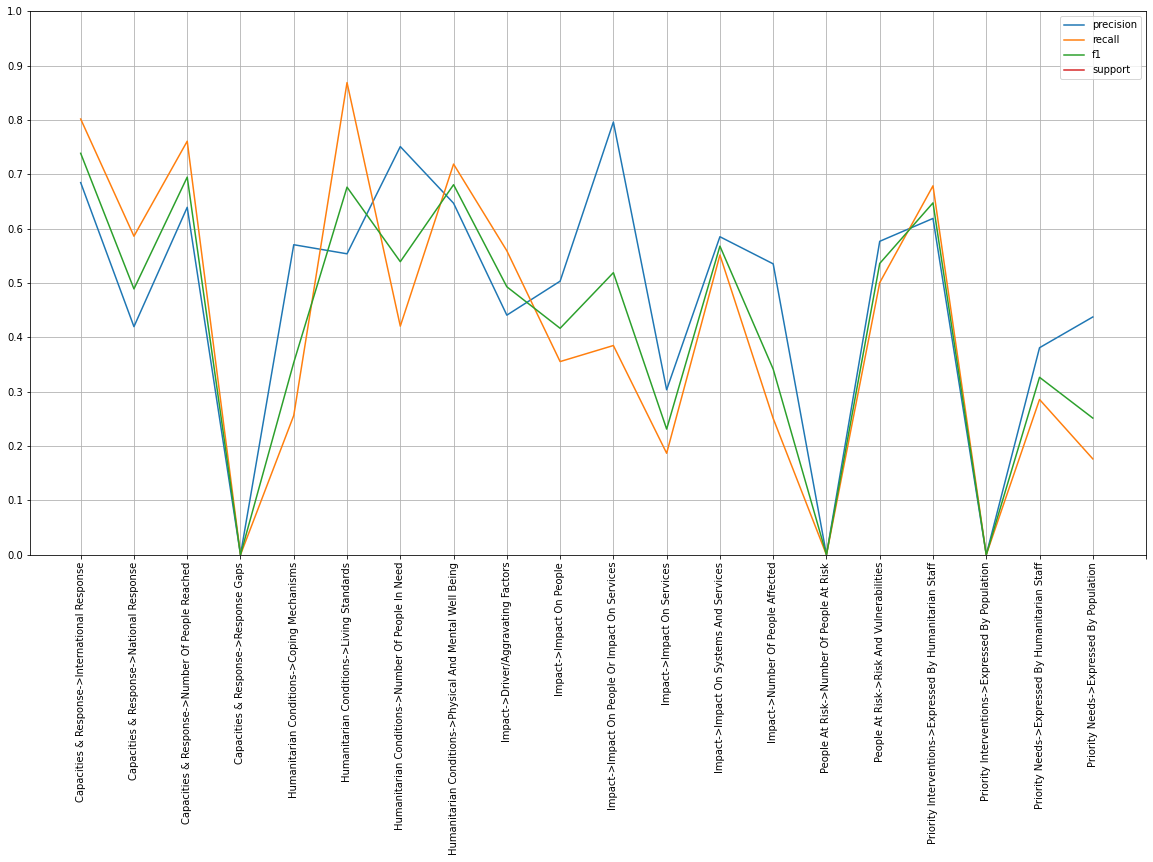

In [53]:
plot(subpillar_metrics)

In [176]:
english_metrics = english_results.get_metrics(0.3)
subpillar_metrics = metrics.loc[SUBPILLARS]

/Users/stefano/miniconda3/envs/deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/stefano/miniconda3/envs/deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [177]:
language_metrics = metrics.join(english_metrics, rsuffix='_english')

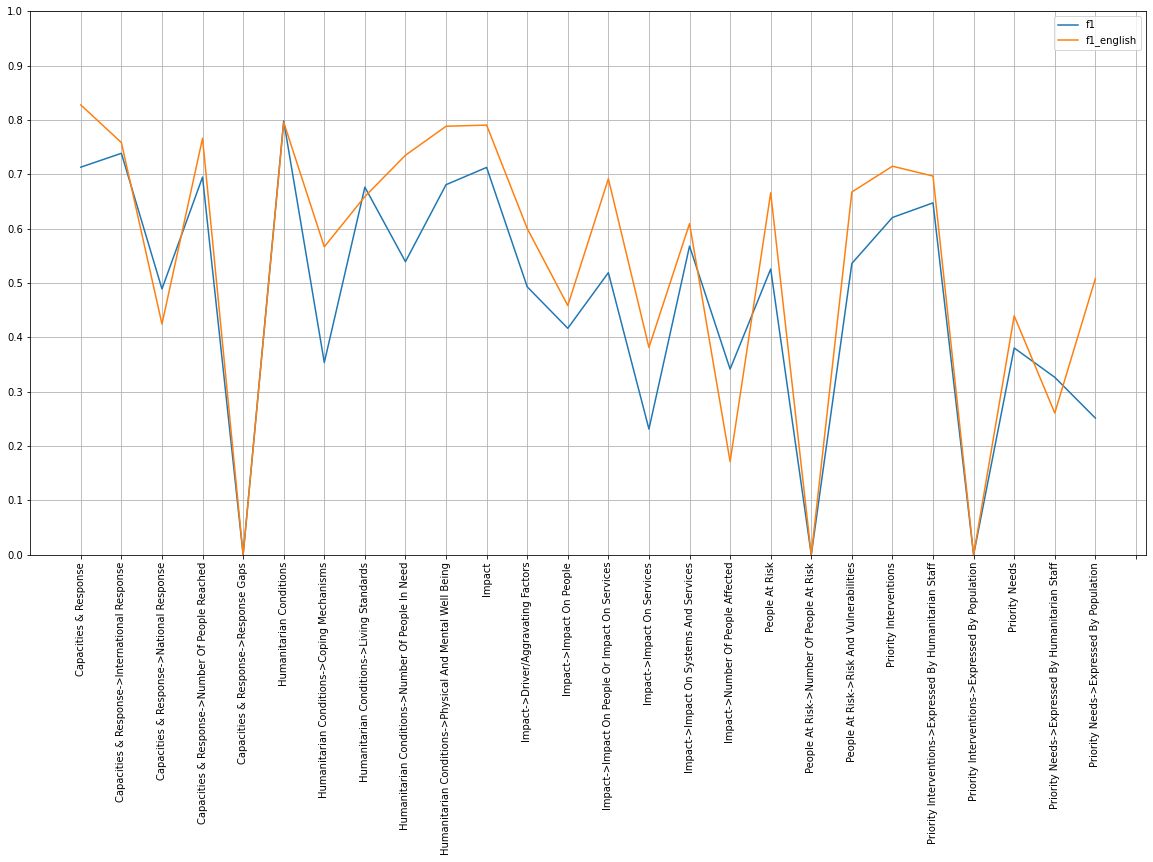

In [180]:
plot(language_metrics[['f1', 'f1_english']])

In [178]:
language_metrics

,precision,recall,f1,support,precision_english,recall_english,f1_english,support_english
Capacities & Response,0.666150,0.767172,0.713101,1121,0.804124,0.852459,0.827586,732
Capacities & Response->International Response,0.684685,0.801688,0.738581,474,0.689394,0.842593,0.758333,432
Capacities & Response->National Response,0.419683,0.586098,0.489123,633,0.381356,0.478723,0.424528,282
Capacities & Response->Number Of People Reached,0.639269,0.760870,0.694789,184,0.735135,0.800000,0.766197,170
Capacities & Response->Response Gaps,0.000000,0.000000,0.000000,9,0.000000,0.000000,0.000000,0
Humanitarian Conditions,0.692163,0.942516,0.798168,3514,0.697186,0.926489,0.795646,1578
Humanitarian Conditions->Coping Mechanisms,0.570423,0.256329,0.353712,316,0.494048,0.664000,0.566553,125
Humanitarian Conditions->Living Standards,0.553716,0.868692,0.676330,2041,0.554437,0.812332,0.659054,746
Humanitarian Conditions->Number Of People In Need,0.750958,0.420601,0.539202,466,0.727723,0.742424,0.735000,198
Humanitarian Conditions->Physical And Mental Well Being,0.646739,0.718723,0.680834,1159,0.753138,0.826953,0.788321,653


## Results by selecting before the pillar

In [109]:
def get_metrics(targets, preds, thresh):
    precision, recall, f1, support = precision_recall_fscore_support(targets, preds>thresh)

    metrics = pd.DataFrame(
        {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'support': support,
        },
        index=epochs5_results.classes
    )
    return metrics

In [110]:
threshold = 0.35

In [111]:
pillar_to_sub = {
    pillar: [x for x in SUBPILLARS if x.startswith(pillar)]
    for pillar in PILLARS
}

In [112]:
pillars_preds = (epochs5_results.test_preds[PILLARS] > threshold).astype(int)

In [113]:
preds = epochs5_results.test_preds.copy()
for pillar, subpillars in pillar_to_sub.items():
    preds.loc[pillars_preds[pillar]==0, subpillars] = 0

In [114]:
met = get_metrics(epochs5_results.test_targets, preds, 0.35)

/Users/stefano/miniconda3/envs/deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


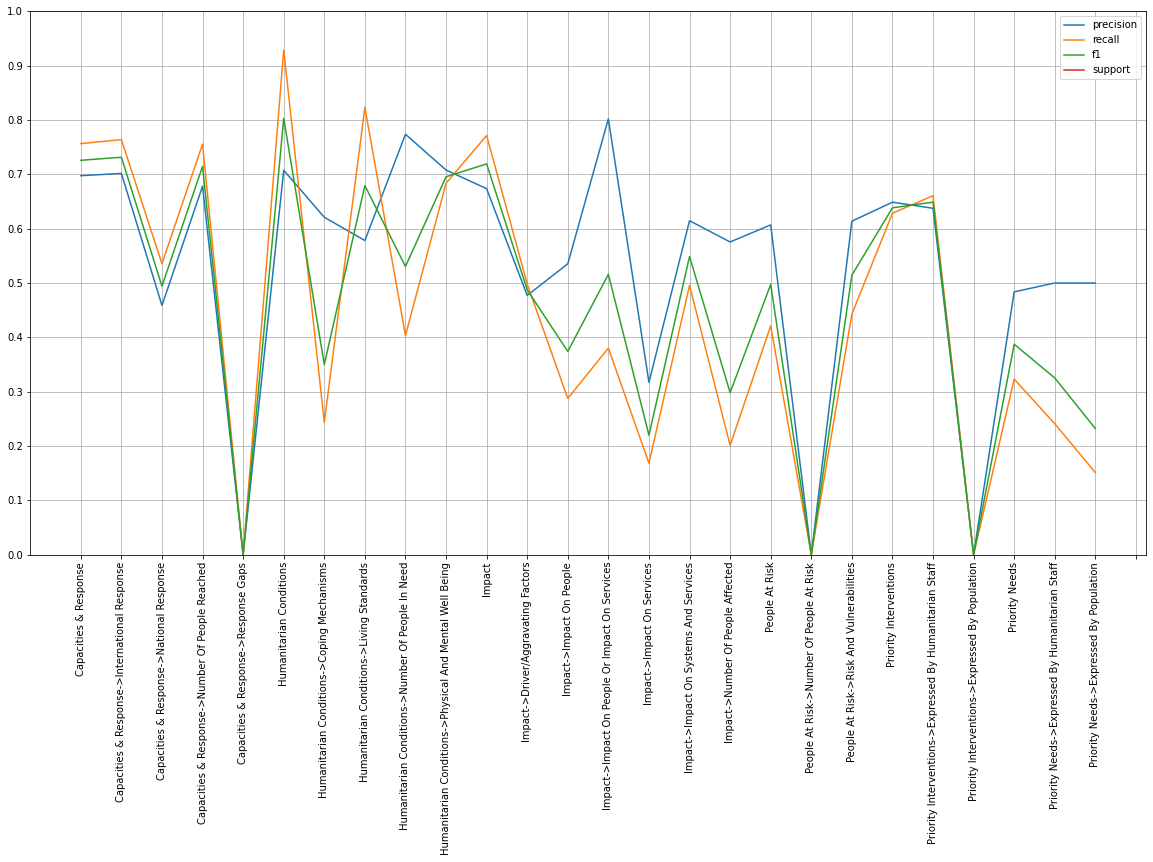

In [115]:
plot(met)

In [116]:
met.join(metrics, rsuffix='_base').mean(axis=0)

precision           0.534963
recall              0.444781
f1                  0.466581
support           698.538462
precision_base      0.501884
recall_base         0.473844
f1_base             0.471309
support_base      698.538462
dtype: float64

## Weighted approach

In [127]:
weighted_preds = epochs5_results.test_preds.copy()
for pillar, subpillars in pillar_to_sub.items():
    weighted_preds[subpillars] * np.reshape(weighted_preds[pillar].values, (weighted_preds.shape[0], 1))

In [138]:
weighted_metrics = get_metrics(epochs5_results.test_targets, weighted_preds, 0.25)

/Users/stefano/miniconda3/envs/deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [155]:
all_metrics = metrics.join(
    met, rsuffix='_pillar_tresh',
).join(
    weighted_metrics, rsuffix='_weighted'
)

In [156]:
all_metrics

,precision,recall,f1,support,precision_pillar_tresh,recall_pillar_tresh,f1_pillar_tresh,support_pillar_tresh,precision_weighted,recall_weighted,f1_weighted,support_weighted
Capacities & Response,0.666150,0.767172,0.713101,1121,0.697368,0.756467,0.725717,1121,0.635328,0.795718,0.706535,1121
Capacities & Response->International Response,0.684685,0.801688,0.738581,474,0.701550,0.763713,0.731313,474,0.661046,0.827004,0.734770,474
Capacities & Response->National Response,0.419683,0.586098,0.489123,633,0.458728,0.535545,0.494169,633,0.380633,0.627172,0.473747,633
Capacities & Response->Number Of People Reached,0.639269,0.760870,0.694789,184,0.678049,0.755435,0.714653,184,0.615063,0.798913,0.695035,184
Capacities & Response->Response Gaps,0.000000,0.000000,0.000000,9,0.000000,0.000000,0.000000,9,0.000000,0.000000,0.000000,9
Humanitarian Conditions,0.692163,0.942516,0.798168,3514,0.707349,0.928571,0.803002,3514,0.677419,0.956175,0.793014,3514
Humanitarian Conditions->Coping Mechanisms,0.570423,0.256329,0.353712,316,0.620968,0.243671,0.350000,316,0.527273,0.275316,0.361746,316
Humanitarian Conditions->Living Standards,0.553716,0.868692,0.676330,2041,0.578114,0.823126,0.679200,2041,0.526781,0.905928,0.666186,2041
Humanitarian Conditions->Number Of People In Need,0.750958,0.420601,0.539202,466,0.773663,0.403433,0.530324,466,0.707746,0.431330,0.536000,466
Humanitarian Conditions->Physical And Mental Well Being,0.646739,0.718723,0.680834,1159,0.707775,0.683348,0.695347,1159,0.585382,0.760138,0.661411,1159


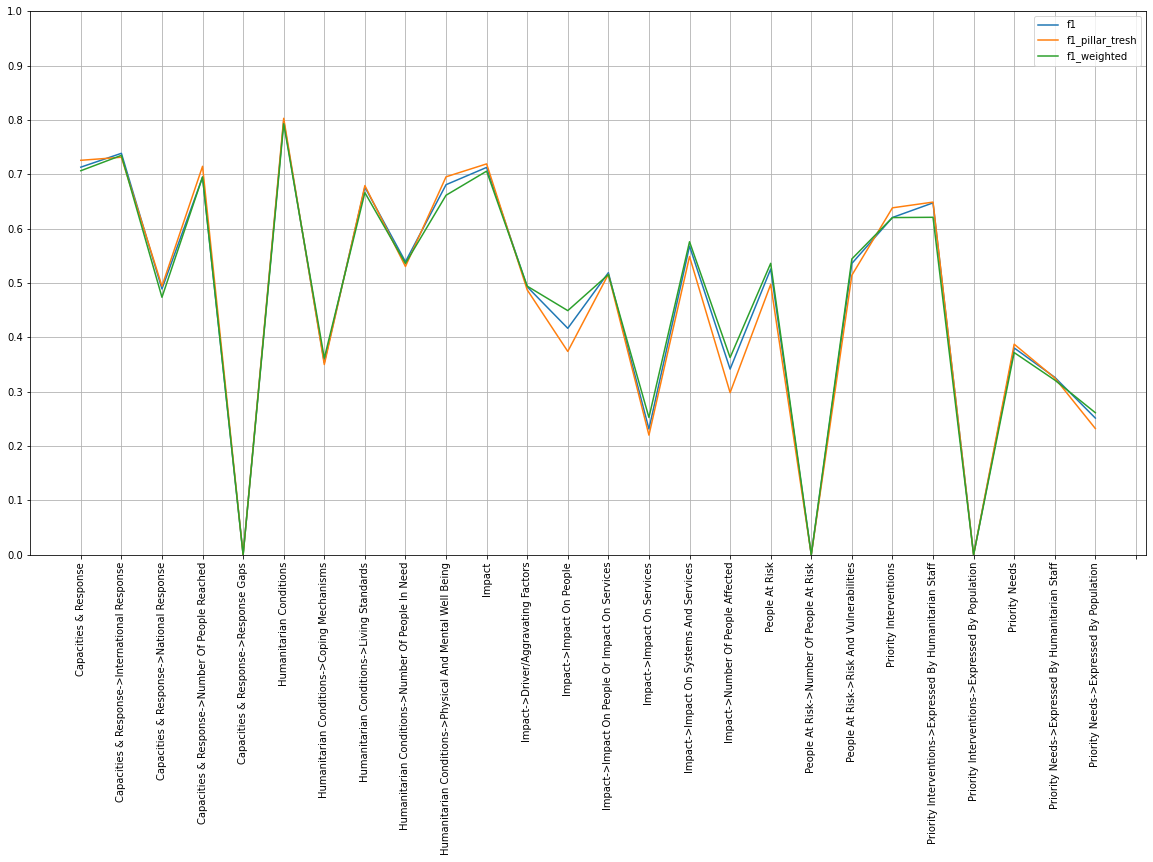

In [159]:
plot(all_metrics[['f1', 'f1_pillar_tresh', 'f1_weighted']])

## Entail Results

In [76]:
english_metrics = english_results.get_metrics(0.3).loc[SUBPILLARS]

/Users/stefano/miniconda3/envs/deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/stefano/miniconda3/envs/deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [91]:
entail_metrics = entail_results.get_metrics(0.3)

/Users/stefano/miniconda3/envs/deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/stefano/miniconda3/envs/deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [96]:
m = english_metrics.join(entail_metrics, rsuffix='_entail')

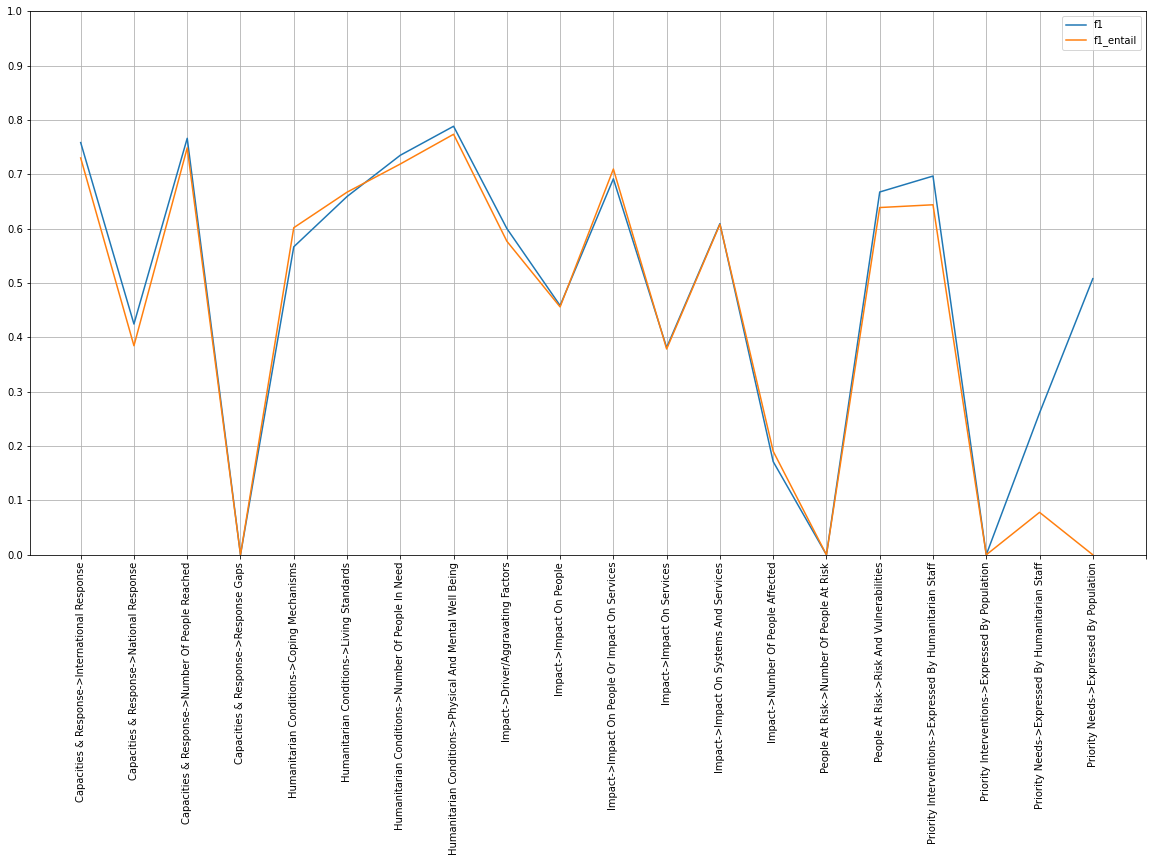

In [97]:
plot(m[['f1', 'f1_entail']])

# Export to file

In [154]:
def matrix_to_list(df, col_name):
    unstacked = df.unstack(0)
    unstacked = unstacked[unstacked != 0]
    df = unstacked.reset_index(level=0)[['level_0']]
    df.columns = [col_name]
    df = pd.DataFrame(df.groupby(level=0)[col_name].apply(lambda x: list(x)))
    return df

In [155]:
output_preds = matrix_to_list((english_results.test_preds > 0.3).astype(int), col_name='Predictions')
output_targets = matrix_to_list(english_results.test_targets, col_name='Targets')

In [177]:
post_test = test[(test.pillars.apply(len)>0) & (test.language=='en')].reset_index()
excerpts = post_test.excerpt
check = pd.DataFrame({'check':post_test.pillars + post_test.subpillars})

In [179]:
output = output_preds.join(output_targets, how='outer').join(excerpts).join(check).dropna()
output.shape

(3377, 4)

In [180]:
output.Predictions = output.Predictions.apply(lambda x: sorted(x))
output.Targets = output.Targets.apply(lambda x: sorted(x))
output.check = output.check.apply(lambda x: sorted(x))

In [182]:
DATA_PATH

Path('/Users/stefano/Dropbox/Work/DFS/Code/deep-experiments/notebooks/models/stefano/../../../data')

In [183]:
OUTPUT_PATH = DATA_PATH / 'streamlit' / 'fastai-5ep-english.pickle'

In [184]:
output.to_pickle(OUTPUT_PATH)